# Object Analysis

## Instructions
1. Fill in the dataset in section 1.1

2. Run all cells

3. Review the summary pdf generated AND/OR explore each metric below.
    - All metrics are identified by a short keyword, and consist of a "Setup" and "Analyses" portion. The "Setup" portion contains code that does not need to be modified unless customization is needed, and the "Analyses" portion provides an interactive display of the results. 

## Table of Contents
1. [Initial Setup](#setup) <br/>
    1.1 [Dataset](#dataset)
2. obj_cnt Metric: [Object counts, duplicate annotations, object cooccurrences](#obj_cnt)<br/>
    2.1 [Setup](#obj_cnt_setup)<br/>
    2.2 [Analyses](#obj_cnt_analyses)
3. obj_siz Metric: [Size and distance from center of supercategories](#obj_siz))<br/>
    3.1 [Setup](#obj_siz_setup)<br/>
    3.2 [Analyses](#obj_siz_analyses)
4. obj_ppl Metric: [Supercategories w/wo people](#obj_ppl)<br/>
    4.1 [Setup](#obj_ppl_setup)<br/>
    4.2 [Analyses](#obj_ppl_analyses)
5. obj_scn Metric: [Scenes and object appearance diversity](#obj_scn)<br/>
    5.1 [Setup](#obj_scn_setup)<br/>
    5.2 [Analyses](#obj_scn_analyses)
6. [Setting up summary pdf](#summarypdf)

# Initial Setup 
<a id="setup"></a>

In [33]:
from __future__ import print_function
import argparse
import os
try: # only change dir if necessary
    import revise_datasets as datasets
except ModuleNotFoundError:
    os.chdir(os.pardir)
    import revise_datasets as datasets
import pickle
import itertools
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from scipy import stats
import PIL.Image
from scipy.cluster.hierarchy import dendrogram, linkage
from math import sqrt
import cv2
import matplotlib.patches as patches
from scipy.spatial.distance import squareform
import pycountry
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re
import plotly.graph_objects as go
import textwrap
import matplotlib.patches as mpatches
import operator
from matplotlib.font_manager import FontProperties
import imageio
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Layout
import ipywidgets as widgets
from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import display
import time
import warnings
import random
from matplotlib.transforms import Bbox
from IPython.display import clear_output

In [34]:
%matplotlib inline

In [35]:
COLORS = sns.color_palette('Set2', 2)
SAME_EXTENT = (-0.5, 6.5, -0.5, 6.5)
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore")

if not os.path.exists("dataloader_files"):
    os.mkdir("dataloader_files")
if not os.path.exists("results"):
    os.mkdir("results")
if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")

In [36]:
# https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
def hide_toggle(for_next=False, toggle_text='Toggle show/hide'):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [37]:
hide_toggle(for_next=True, toggle_text='Show/hide helper functions')

In [38]:
def folder(num, folder):
    if not os.path.exists("results/{0}/{1}".format(folder, num)):
        os.mkdir("results/{0}/{1}".format(folder, num))
    file = open("results/{0}/{1}/results.txt".format(folder, num), "w")
    return file

# Projecting a set of features into a lower-dimensional subspace with PCA
def project(features, dim):
    standardized = StandardScaler().fit_transform(features)
    pca = PCA(n_components=dim)
    principalComponents = pca.fit_transform(X=standardized)
    return principalComponents

# Calculating the binomial proportion confidence interval
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

def country_to_iso3(country):
    missing = {'South+Korea': 'KOR',
            'North+Korea': 'PRK',
            'Laos': 'LAO',
            'Caribbean+Netherlands': 'BES',
            'St.+Lucia': 'LCA',
            'East+Timor': 'TLS',
            'Democratic+Republic+of+Congo': 'COD',
            'Swaziland': 'SWZ',
            'Cape+Verde': 'CPV',
            'C%C3%B4te+d%C2%B4Ivoire': 'CIV',
            'Ivory+Coast': 'CIV',
            'Channel+Islands': 'GBR'
            }
    try:
        iso3 = pycountry.countries.search_fuzzy(country.replace('+', ' '))[0].alpha_3
    except LookupError:
        try:
            iso3 = missing[country]
        except KeyError:
            iso3 = None
    return iso3

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

def display_filepaths(filepaths, width=100, height=100):
    sidebyside = widgets.HBox([widgets.Image(value=open(filepath, 'rb').read(), format='png', width=width, height=height) for filepath in filepaths], layout=Layout(height='{}px'.format(height)))
    display(sidebyside)

# hide_toggle(toggle_text='Show/hide helper functions')

## Dataset
Fill in below with dataset and file path names
<a id="dataset"></a>

In [39]:
transform_train = transforms.Compose([ 
        transforms.ToTensor()
        ])
dataset = datasets.CoCoDataset(transform_train)
folder_name = 'coco_example'

# dataset = datasets.OpenImagesDataset(transform_train)
# folder_name = 'openimages_supp'

loading annotations into memory...
Done (t=11.08s)
creating index...
index created!


In [40]:
save_loc = '1_pager_obj'
os.system("rm -r results/{0}/{1}".format(folder_name, save_loc))
file = folder(save_loc, folder_name)
first_pass = True
to_write = {}

In [41]:
data_folder = "G:/Github/revise-tool/Data/Coco/2014data/train2014/"
info = pickle.load(open("results/{}/obj_cnt.pkl".format(folder_name), "rb"))
sample_file = info['filepaths'][0][0]
if not os.path.exists(sample_file):
    assert data_folder is not None, "initialize data_folder with folder path of your data"
    dataset.init_folder_path(data_folder)
    print("overwriting from_path() function")
    dataset.from_path = dataset.from_path_prerun

overwriting from_path() function


# obj_cnt Metric: Object Counts, Duplicate Annotations, Object Co-Occurrences
<a id="obj_cnt"></a>

## Setup
<a id="obj_cnt_setup"></a>

In [42]:
hide_toggle(for_next=True, toggle_text='Show/hide obj_cnt Code')

In [43]:
categories = dataset.categories
names = dataset.labels_to_names
if not os.path.exists("results/{0}/0/".format(folder_name)):
    os.mkdir("results/{0}/0/".format(folder_name))
info = pickle.load(open("results/{}/obj_cnt.pkl".format(folder_name), "rb"))
instances_size = info['instances_size']
supercat_filepaths = info['filepaths']
same = []
not_same = {}
with_people = info['with_people']
not_with_people = info['not_with_people']
counts = info['counts']
overlap = info['overlap']
threshold = .6
for key in overlap.keys():
    rat = overlap[key] / counts[key]
    if overlap[key] / counts[key] > threshold:
        same.append(key)
    else:
        not_same[key] = rat

# Setting up the cooccurrence matrix
counts_mat = np.zeros((len(categories), len(categories)))
cooccurs = []
for key in counts.keys():
    a, b = key.split('-')
    a, b = int(a), int(b)
    counts_mat[b][a] = counts[key]
    counts_mat[a][b] = counts[key]
    if a != b:
        cooccurs.append(counts[key])
instance_counts = np.diagonal(counts_mat)

mi_wilson = np.zeros((len(categories), len(categories)))
mi = np.zeros((len(categories), len(categories)))
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        denom = instance_counts[j] + instance_counts[i] - counts_mat[i][j]
        mi_wilson[i][j] = wilson(counts_mat[i][j] / denom, denom)[0]
        mi[i][j] = counts_mat[i][j]/denom

normalized = np.divide(counts_mat, instance_counts)
for i in range(len(categories)):
    normalized[i][i] = -1
    mi_wilson[i][i] = -1
for people in dataset.people_labels:
    index = categories.index(people)
    mi_wilson[index] = -1
    mi_wilson[:, index] = -1
    normalized[index] = -1
    normalized[:, index] -1
flat_norm = normalized.flatten()

def instance_counts_words(topn):
    instance_indices = np.argsort(instance_counts)
    print("Top appearances:")
    for i in range(topn):
        index = instance_indices[-1-i]
        print("{0}: {1}".format(names[categories[index]], int(instance_counts[index])))

    print("\nBottom appearances:")
    for i in range(topn):
        index = instance_indices[i]
        print("{0}: {1}".format(names[categories[index]], int(instance_counts[index])))

def instance_counts_graph(log):
    %matplotlib inline
    if log:
        hist, bins = np.histogram(instance_counts, bins='fd')
        left = 0 if bins[0] == 0 else np.log10(bins[0])
        logbins = np.logspace(left,np.log10(bins[-1]),len(bins) // 3)
        n, bins, patches = plt.hist(instance_counts, bins=logbins)
        plt.yticks([])
        plt.xscale('log')
        plt.xlabel('Number of Instance Occurrences')
        plt.ylabel('Frequency')
        plt.title('Distribution of Log Instance Occurrences')
        z = np.abs(stats.zscore(np.log(instance_counts+1e-6)))
        outliers = np.where(z > 3)[0]
        if first_pass and len(outliers) > 0:
            to_write[0] = ["(obj_cnt) The outliers shown on the graph for instance count are:"]
            outliers_added = 0
            for outlier in outliers:
                outliers_added += 1
                patches[max(np.digitize(instance_counts[outlier], bins, right=False) - 1, 0)].set_facecolor('C1')
                if outliers_added < 5:
                    to_write[0].append("{0}: {1}".format(names[categories[outlier]], int(instance_counts[outlier])))
                if outliers_added == 5:
                    to_write[0].append("Look in the notebook for the rest of the outliers.")
            plt.savefig("results/{0}/{1}/1.png".format(folder_name, save_loc))
            for outlier in outliers:
                patches[max(np.digitize(instance_counts[outlier], bins, right=False) - 1, 0)].set_facecolor('C0')
        plt.show()
        
        
    else:
        plt.hist(instance_counts, bins='fd')
        plt.xlabel('Number of Instance Occurrences')
        plt.ylabel('Frequency')
        plt.title('Distribution of Instance Occurrences')
        plt.show()

flat_norm = mi_wilson.flatten()
flat_norm[flat_norm!=flat_norm] = -1.
normalized_indices_top = np.argsort(flat_norm)

flat_norm[flat_norm == -1] = float("inf")
normalized_indices_bot = np.argsort(flat_norm)

def cooccurrence_counts_words(topn):
    same_notadded = []
    print("Top cooccurrences:")
    for i in range(topn):
        index = normalized_indices_top[-1-i]
        a, b = index % len(categories), index // len(categories)
        key = '{0}-{1}'.format(b, a)
        if key not in same:
            round_flat_norm = 0.0 if round(flat_norm[index], 4) == 0 else round(flat_norm[index], 4)
            print("{0} - {1}: {2}".format(names[categories[a]], names[categories[b]], round_flat_norm))
        else:
            same_notadded.append(key)
    
    print("\nBottom cooccurrences:")
    for i in range(topn):
        index = normalized_indices_bot[i]
        a, b = index % len(categories), index // len(categories)
        round_flat_norm = 0.0 if round(flat_norm[index], 4) == 0 else round(flat_norm[index], 4)
        print("{0} - {1}: {2}".format(names[categories[a]], names[categories[b]], round_flat_norm))
        
    print('\nNot included in above rankings because most likely the same object:')
    if same_notadded == []:
        print("N/A")
    for notadded in same_notadded:
        a, b = notadded.split('-')
        print("{0} - {1}".format(names[categories[int(a)]], names[categories[int(b)]]))

def cooccurence_counts_graph(log):
    %matplotlib inline
    if log:
        hist, bins = np.histogram(cooccurs, bins='fd')
        if len(bins) < 20:
            hist, bins = np.histogram(cooccurs, bins=20)
        left = 0 if bins[0] == 0 else np.log10(bins[0])
        logbins = np.logspace(left,np.log10(bins[-1]),len(bins))
        n, bins, patches = plt.hist(cooccurs, bins=logbins)
        plt.xscale('log')
        plt.xlabel('Number of Instance Cooccurrences')
        plt.ylabel('Frequency')
        plt.title('Distribution of Log Instance Occurrences')
        plt.show()
        plt.close()
    else:
        hist, bins = np.histogram(cooccurs, bins='fd')
        if len(bins) < 20:
            hist, bins = np.histogram(cooccurs, bins=20)
        plt.hist(cooccurs, bins=bins)
        plt.xlabel('Number of Instance Cooccurrences')
        plt.ylabel('Frequency')
        plt.title('Distribution of Cooccurrences')
        plt.show()


num_images = len(dataset.image_ids)
group_mapping = dataset.group_mapping
if group_mapping is not None:
    num_per_group = np.zeros(len(with_people))
    freqs_per_group = [[] for i in range(len(with_people))]
    names_per_group = [[] for i in range(len(with_people))]
    ps = []
    phrases = []
    for cat in dataset.categories:
        num_per_group[group_mapping(cat)] += 1
    with_people = info['with_people']
    not_with_people = info['not_with_people']
    number_images = np.add(with_people, not_with_people)
    counts = info['counts']
    for i in range(len(instance_counts)):
        supercategory = group_mapping(dataset.categories[i])
        freqs_per_group[supercategory].append(instance_counts[i])
        names_per_group[supercategory].append(dataset.labels_to_names[dataset.categories[i]])
        if num_per_group[supercategory] > 1:
            this_counts = np.zeros(num_images)
            this_counts[:int(instance_counts[i])] = 1
            that_counts = np.zeros(num_images)
            rest_counts = (number_images[supercategory] - instance_counts[i]) / (num_per_group[supercategory] - 1)
            that_counts[:int(rest_counts)] = 1
            p = stats.ttest_ind(this_counts, that_counts)[1]
            p = stats.binomtest(int(instance_counts[i]), n=num_images, p=np.mean(that_counts)).pvalue
            if p < .05:
                if np.mean(this_counts) > np.mean(that_counts):
                    phrase = '{0} is over represented in the {1} category: {2}, {3}, {4}\n'.format(dataset.labels_to_names[dataset.categories[i]], dataset.supercategories_to_names[supercategory], round(np.mean(this_counts), 4), round(np.mean(that_counts), 4), p)
                else:
                    phrase = '{0} is under represented in the {1} category: {2}, {3}, {4}\n'.format(dataset.labels_to_names[dataset.categories[i]], dataset.supercategories_to_names[supercategory], round(np.mean(this_counts), 4), round(np.mean(that_counts), 4), p)

                phrase = '{0} '.format(instance_counts[i]) + phrase
                ps.append(p)
                phrases.append(phrase)
    indices = np.argsort(ps)
    
def within_category(category):
    %matplotlib inline
    
    topn = 10

    # looking at distribution within supercategory 
    fontsize = 20
    fig = plt.figure(figsize=(14, 5))
    grid = plt.GridSpec(1, 2, hspace=.2, wspace=.3)
    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[0, 1])

    total = with_people+not_with_people
    names = [dataset.supercategories_to_names[i] for i in range(len(total))]

    ax1.set_xlabel('Supercategory', fontsize=fontsize)
    ax1.set_ylabel('Frequency', fontsize=fontsize)
    ax1.set_title('Supercategories', size=fontsize)
    order = np.argsort(total)[::-1]
    pltbar = ax1.bar(np.arange(len(total)), np.array(total)[order], tick_label=np.array(names)[order])
    for tick in ax1.get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize(fontsize)
    for tick in ax1.get_yticklabels():
        tick.set_fontsize(fontsize)
    ax1.xaxis.labelpad = 10
    ax1.yaxis.labelpad = 10
    
    if first_pass and not os.path.exists('results/{0}/{1}/3.png'.format(folder_name, save_loc)):
        to_write[2] = ["(obj_cnt) Distribution of object categories that appear in dataset."]
        extent = full_extent(ax1, pad=0.3).transformed(fig.dpi_scale_trans.inverted())
        fig.savefig('results/{0}/{1}/3.png'.format(folder_name, save_loc), bbox_inches=extent)

    stds_per_group = [np.std(chunk) for chunk in freqs_per_group]
#         peakiest_supercat = np.argmax(stds_per_group)
    reverse = {v: k for k, v in dataset.supercategories_to_names.items()}
    peakiest_supercat = reverse[category]
    pltbar[list(order).index(peakiest_supercat)].set_color('C1')

    ax2.set_xlabel('Instance Label', fontsize=fontsize)
    ax2.set_ylabel('Frequency', fontsize=fontsize)
    ax2.set_title('Within "{}"'.format(dataset.supercategories_to_names[peakiest_supercat]), size=fontsize)
    freqs = freqs_per_group[peakiest_supercat]
    order = np.argsort(freqs)[::-1]
    ax2.bar(np.arange(len(freqs_per_group[peakiest_supercat])), np.array(freqs)[order], tick_label=np.array(names_per_group[peakiest_supercat])[order], color='C1')
    for tick in ax2.get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize(fontsize)
    for tick in ax2.get_yticklabels():
        tick.set_fontsize(fontsize)
    ax2.xaxis.labelpad = 10
    ax2.yaxis.labelpad = 10

    plt.show()
    plt.close()
    
    try: 
        filepaths = supercat_filepaths[peakiest_supercat]

        fig = plt.figure(figsize=(17,5))
        for i in range(21):
            filepath = filepaths[i]
            image, anns = dataset.from_path(filepath)
            image = image.data.cpu().numpy().transpose(1, 2, 0)
            ax = fig.add_subplot(3, 7, 1+i)
            im = ax.imshow(image, alpha=.6)
            this_instances = set()
            for ann in anns[0]:
                if group_mapping(ann['label']) == peakiest_supercat:
                    this_instances.add(dataset.labels_to_names[ann['label']])
                    bbox = ann['bbox']

                    ann_0 = (bbox[0]*image.shape[1], bbox[2]*image.shape[0])
                    ann_w = (bbox[1]-bbox[0])*image.shape[1]
                    ann_h = (bbox[3]-bbox[2])*image.shape[0]
                    rect = patches.Rectangle(ann_0,ann_w, ann_h, linewidth=2,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
            ax.set_title(', '.join(list(this_instances)), size=10)
            ax.axis("off")
            
        plt.show()
        plt.close()
    except AttributeError: 
        print('Some functionality not available for CocoDatasetNoImages Class')
    

def show_cooccurrence_hierarchy():
    reverse = {v: k for k, v in dataset.labels_to_names.items()}
    mi_wilson[np.isnan(mi_wilson)] = 0
    xaxis = [dataset.labels_to_names[i] for i in categories]
    biggest = np.amax(mi_wilson)*1.1
    condensed_distance_matrix = []
    for i in range(len(categories)):
        for j in range(i+1, len(categories)):
            condensed_distance_matrix.append(biggest - mi_wilson[i][j])

    for p in [20]: # change this to have more or less labels shown
        Z = linkage(condensed_distance_matrix, 'ward')
        fig = plt.figure(figsize=(15, 10))
        dn = dendrogram(Z, orientation='left', labels=xaxis, p=p, truncate_mode='level')
        ax = plt.gca()
        xlbls = ax.get_ymajorticklabels()
        colorz = sns.color_palette('Set2', 12)
        if dataset.group_mapping is not None:
            for lbl in xlbls:
                if lbl.get_text() not in reverse.keys():
                    continue
                ind = reverse[lbl.get_text()]
                lbl.set_color(colorz[dataset.group_mapping(ind)])
        plt.savefig("results/{0}/{1}/hierarchy_{2}.png".format(folder_name, 'obj_cnt', p), dpi=300)
        plt.close()
        
    # Create figure
    fig = go.Figure()

    # Constants
    img_width = 1600
    img_height = 900
    scale_factor = 0.5

    # Add invisible scatter trace.
    # This trace is added to help the autoresize logic work.
    fig.add_trace(
        go.Scatter(
            x=[0, img_width * scale_factor],
            y=[0, img_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )

    # Configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width * scale_factor]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height * scale_factor],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # Add image
    fig.add_layout_image(
        dict(
            x=0,
            sizex=img_width * scale_factor,
            y=img_height * scale_factor,
            sizey=img_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source="results/{0}/{1}/hierarchy_{2}.png".format(folder_name, 'obj_cnt', p)))
    

    # Configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )

    # Disable the autosize on double click because it adds unwanted margins around the image
    # More detail: https://plot.ly/python/configuration-options/
    fig.show(config={'doubleClick': 'reset'})

## Analyses
<a id="obj_cnt_analyses"></a>

Looking at individual object counts

In [44]:
print("Number of images: {}".format(len(dataset.image_ids)))
print("Median and Mean of instance counts: {0}, {1}".format(int(np.median(instance_counts)), int(np.mean(instance_counts))))
interact(instance_counts_words, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));
interact(instance_counts_graph, log=widgets.ToggleButton(value=True, description="Toggle for log"));

Number of images: 82081
Median and Mean of instance counts: 2225, 3012


interactive(children=(IntSlider(value=10, description='topn', max=30, min=1), Output()), _dom_classes=('widget…

interactive(children=(ToggleButton(value=True, description='Toggle for log'), Output()), _dom_classes=('widget…

Looking at cooccurrence counts in the form of numbers, graph, and a hierarchy. <br>
Note: Scores are calculated using the Wilson score interval, which is a confidence interval for the probability that two items coocurr in the same image.

In [45]:
print("Median and Mean of cooccurrence counts: {0}, {1}".format(np.median(cooccurs), np.mean(cooccurs)))
interact(cooccurrence_counts_words, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));
interact(cooccurence_counts_graph, log=widgets.ToggleButton(value=True, description="Toggle for log"));

Median and Mean of cooccurrence counts: 9.0, 117.30411392405064


interactive(children=(IntSlider(value=10, description='topn', max=30, min=1), Output()), _dom_classes=('widget…

interactive(children=(ToggleButton(value=True, description='Toggle for log'), Output()), _dom_classes=('widget…

Visualizing a hierarchy of terms based on their cooccurrences. Interact with the graph to zoom in and out. Can change settings of graph to have more/fewer labels in the show_cooccurrence_hierarchy function above.

FileNotFoundError: [Errno 2] No such file or directory: 'results/coco_example/obj_cnt/hierarchy_20.png'

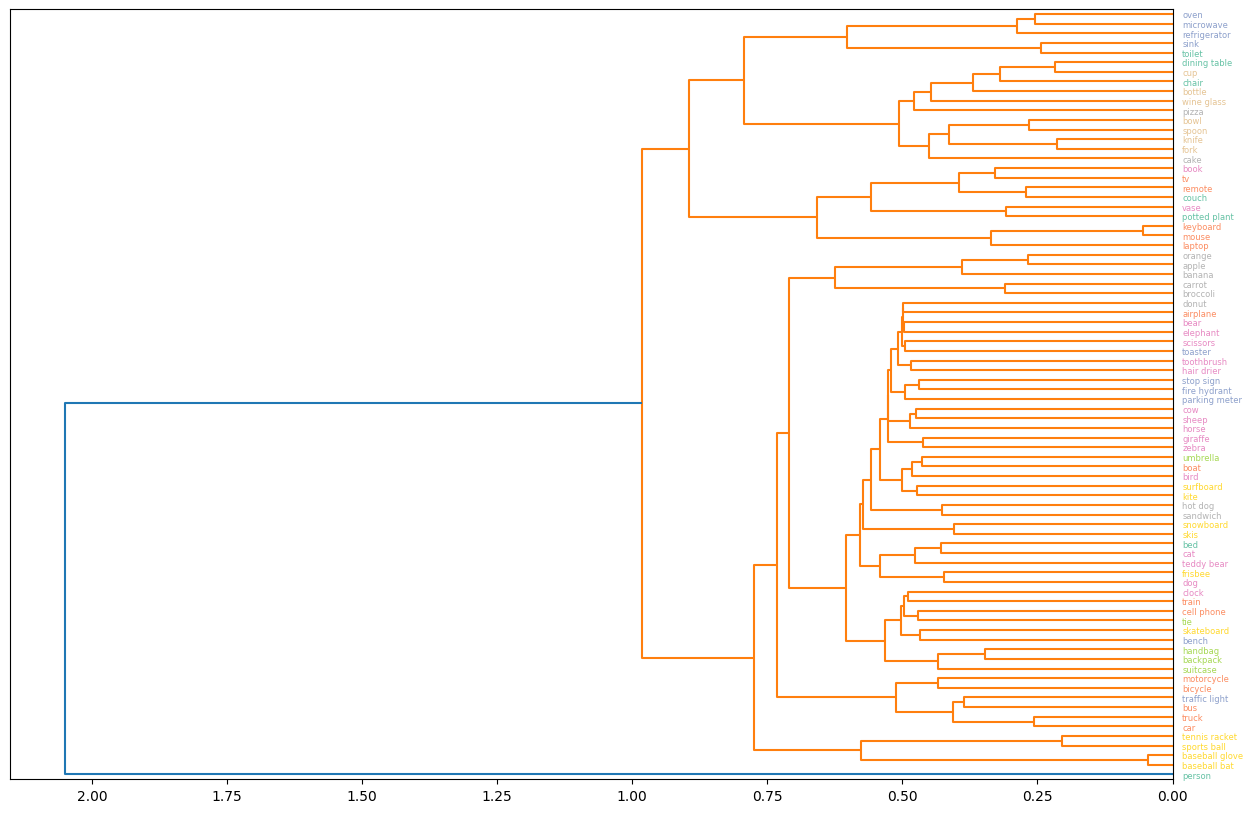

In [46]:
show_cooccurrence_hierarchy()

A look at the supercategory level

In [47]:
if group_mapping is not None:
    interact(within_category, category=widgets.Dropdown(options=sorted(list(dataset.supercategories_to_names.values())), value='accessory'));

interactive(children=(Dropdown(description='category', options=('accessory', 'animal', 'appliance', 'electroni…

# obj_siz Metric: Size and Distance from Center of Supercategories
<a id="obj_siz"></a>

## Setup 
<a id="obj_siz_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide obj_siz Code')

In [48]:
topn = 15
categories = dataset.categories
idx_to_scenegroup = pickle.load(open('util_files/places_scene_info.pkl', 'rb'))['idx_to_scenegroup']
info = pickle.load(open("results/{}/obj_cnt.pkl".format(folder_name), "rb"))

if dataset.group_mapping is not None:
    sizes = info['sizes']
    distances = info['distances']

    all_sizes = np.concatenate([np.array(size) for size in sizes], axis=0)
    
else:
    all_sizes = []
    for a_instance_size in instances_size:
        for a_size in a_instance_size:
            all_sizes.append(a_size[0])

sorted_sizes = np.sort(all_sizes)
fifth = len(sorted_sizes) // 5
bins = [sorted_sizes[i*fifth] for i in range(5)]
bins.append(1.00001)

bar_mapping = {1: 'XS', 2: 'S', 3: 'M', 4: 'L', 5: 'XL'}
reverse_bm = {v: k for k, v in bar_mapping.items()}

instances_sizes = info['instances_size']
instance_deviations = np.zeros(len(instances_sizes))
for i in range(len(instances_sizes)):
    this_sizes = [chunk[0] for chunk in instances_sizes[i]]
    this_bins = np.digitize(this_sizes, bins)
    _, counts = np.unique(this_bins, return_counts=True)
    probs = counts / np.sum(counts)
    entropy = -np.sum(np.multiply(probs, np.log2(probs+1e-6)), axis=0)
    instance_deviations[i] = entropy
indices = np.argsort(instance_deviations)
counts = pickle.load(open('results/{}/obj_cnt.pkl'.format(folder_name), 'rb'))['counts']
counts_mat = np.zeros((len(categories), len(categories)))
cooccurs = []
for key in counts.keys():
    a, b = key.split('-')
    a, b = int(a), int(b)
    counts_mat[b][a] = counts[key]
    counts_mat[a][b] = counts[key]
    if a != b:
        cooccurs.append(counts[key])
scene_instance = pickle.load(open("results/{}/obj_scn.pkl".format(folder_name), "rb"))['scene_instance']

def mean_and_std(data, data_type):
    %matplotlib inline
    colorz = sns.color_palette('Set2', len(data))

    f = data[0]
    m = data[1]
    means = []
    stds = []
    x = []
    name = []
    for i, cat in enumerate(data):
        x.append(i)
        means.append(np.mean(cat))
        stds.append(np.std(cat))
        name.append(dataset.supercategories_to_names[i])

        histogram, bins = np.histogram(cat, bins='auto')
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        area = np.trapz(histogram, x=bin_centers)
        plt.plot(bin_centers, histogram/area, alpha=.75, label=dataset.supercategories_to_names[i], color=colorz[i])

    plt.legend(loc='upper right')
    plt.xlabel(data_type)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    plt.close()

    sns.boxplot(data=data, showfliers=False) #outliers not shown 
    plt.xticks(plt.xticks()[0], name, rotation='vertical')
    plt.xlabel('Category Groups')
    plt.ylabel(data_type)
    plt.tight_layout()
    z = np.abs(stats.zscore(means))
    outliers = np.where(z > 3)[0]
    if data_type == 'Distances' and first_pass and len(outliers) > 0:
        to_write[3] = ["(obj_siz) In the graph, the following object(s) have outlier distances:"]
        for outlier in outliers:
            to_write[3].append(name[outlier])
        plt.savefig("results/{0}/{1}/4.png".format(folder_name, save_loc))
    plt.show()
    plt.close()

def size_or_distance(metric):
    if metric == 'size':
        mean_and_std(sizes, 'Sizes')
    elif metric == 'distance':
        mean_and_std(distances, 'Distances')

cat_to_ent = [('{0}: {1}'.format(dataset.labels_to_names[categories[index]], round(instance_deviations[index], 3)), index) for index in indices if len(instances_sizes[index]) > 10]

def object_size(object_class, sizes):
    try: 
        plt.clf()
        index = object_class
        cat = categories[index]
        fontsize = 10
        this_sizes = [chunk[0] for chunk in instances_sizes[index]]
        this_bins = np.digitize(this_sizes, bins)
        num, counts = np.unique(this_bins, return_counts=True)
        fig = plt.figure(figsize=(5, 4))
        ax = plt.subplot(111)
        xticks = []
        for j in bar_mapping.keys():
            if j in num:
                ax.bar(j, counts[list(num).index(j)], width=0.8, bottom=0.0, align='center', color='C0')
            else:
                ax.bar(j, 0, width=0.8, bottom=0.0, align='center', color='C0')
            ax.plot(1,1,label = '{0}: {1}-{2}'.format(bar_mapping[j], round(bins[j-1], 3), round(bins[j], 3)),marker = '',ls ='')
            xticks.append(bar_mapping[j])
        plt.xticks(np.arange(len(xticks))+1, xticks, fontsize=fontsize)
        plt.tick_params(labelsize=fontsize)
        plt.xlabel('Size Bins', fontsize=fontsize)
        plt.ylabel('Frequency', fontsize=fontsize)
        plt.tight_layout()
        plt.gcf().subplots_adjust(left=0.35)

        if sizes is None:
            if len(counts) == 1:
                size_to_add = [num[0]]
            else:
                size_to_add = num[np.argpartition(counts, 2)[:2]]
            plt.savefig("results/{0}/{1}/5.png".format(folder_name, save_loc))
            plt.close()
        else:
            size_to_add = [reverse_bm[size] for size in sizes]
            plt.show()
            plt.close()
        filepaths = [instances_sizes[index][j][1] for j in range(len(instances_sizes[index])) if this_bins[j] in size_to_add]
        if len(filepaths) == 0:
            print("No images of objects in this size appear in the dataset. Please select an additional size.")
            return
        other_instances = counts_mat[index]
        other_scenes = scene_instance[:, index]

        all_anns = [dataset.from_path(filepath)[1][0] for filepath in filepaths]
        instances_per = np.array([list(set([ann['label'] for ann in anns if ann['label'] != cat])) for anns in all_anns])
        these_instances = np.concatenate(instances_per, axis=0)
        scenes_per = np.array([dataset.from_path(filepath)[1][4] for filepath in filepaths])
        these_scenes = np.concatenate(scenes_per, axis=0)
        num, counts = np.unique(these_instances, return_counts=True)
        num = np.array([categories.index(nu) for nu in num])
        these_instances = np.zeros(len(categories))
        for i in range(len(num)):
            these_instances[num[i]] = counts[i]

        num, counts = np.unique(these_scenes, return_counts=True)
        these_scenes = np.zeros(len(other_scenes))
        for i in range(len(num)):
            these_scenes[num[i]] = counts[i]

        instance_probs = np.nan_to_num(np.divide(these_instances, other_instances))
        instance_probs = np.nan_to_num(np.array([wilson(instance_probs[i], other_instances[i])[0] for i in range(len(instance_probs))]))
        scene_probs = np.nan_to_num(np.divide(these_scenes, other_scenes))
        scene_probs = np.nan_to_num(np.array([wilson(scene_probs[i], other_scenes[i])[0] for i in range(len(scene_probs))]))
        instance_indices = np.argsort(instance_probs)
        scene_indices = np.argsort(scene_probs)
        i_counter = 1
        s_counter = 1
        imgs_to_show =3
        i_indices = []
        s_indices = []
        fig = plt.figure(figsize=(8, 6))
        i = 0
        start = time.time()

        # so that it displays combos even of object of interest in non-desired size
        if sizes is not None:
            print("Please wait, visualization can take ~25 seconds")
        filepaths = [instances_sizes[index][j][1] for j in range(len(instances_sizes[index]))]
        things_per = np.array([dataset.from_path(filepath)[1] for filepath in filepaths])
        scenes_per = np.array([thing[4] for thing in things_per])
        all_anns = [thing[0] for thing in things_per]
        instances_per = np.array([list(set([ann['label'] for ann in anns if ann['label'] != cat])) for anns in all_anns])
        if sizes is not None:
            print("Time took: {}".format(time.time() - start))
        fontsize = 10
        added_filepaths = []
        second_queries = []
        second_probs = []
        while i < imgs_to_show:
            if i_counter > len(instance_indices) or s_counter > len(scene_indices):
                break
            if instance_probs[instance_indices[-i_counter]] < scene_probs[scene_indices[-s_counter]]:
                s_index = scene_indices[-s_counter]
                s_counter += 1
                added = 0
                for j, scenes in enumerate(scenes_per):
                    if s_index in scenes:
                        filepath = filepaths[j]
                        if filepath in added_filepaths:
                            continue
                        added_filepaths.append(filepath)
                        image, anns = dataset.from_path(filepath)
                        image = image.data.cpu().numpy().transpose(1, 2, 0)
                        ax = fig.add_subplot(3, imgs_to_show, (added*imgs_to_show)+1+i)
                        ax.clear()
                        ax.set_title('\n'.join(textwrap.wrap(idx_to_scenegroup[s_index], width=25)), fontsize=fontsize)
                        ax.axis("off")
                        for ann in anns[0]:
                            if ann['label'] == cat:
                                bbox = ann['bbox']
                                ann_0 = (bbox[0]*image.shape[1], bbox[2]*image.shape[0])
                                ann_w = (bbox[1]-bbox[0])*image.shape[1]
                                ann_h = (bbox[3]-bbox[2])*image.shape[0]
                                rect = patches.Rectangle(ann_0,ann_w, ann_h, linewidth=2,edgecolor='#ff0000',facecolor='none')
                                ax.add_patch(rect)
                        im = ax.imshow(image, alpha=.66)
                        added += 1
                    if added == 3:
                        second_queries.append('\n'.join(textwrap.wrap(idx_to_scenegroup[s_index], width=20)))
                        second_probs.append(scene_probs[s_index])
                        break
            else:
                i_index = instance_indices[-i_counter]
                i_counter += 1
                added = 0
                for j, instances in enumerate(instances_per):
                    if categories[i_index] in instances:
                        filepath = filepaths[j]
                        if filepath in added_filepaths:
                            continue
                        added_filepaths.append(filepath)
                        image, anns = dataset.from_path(filepath)
                        image = image.data.cpu().numpy().transpose(1, 2, 0)
                        ax = fig.add_subplot(3, imgs_to_show, (added*imgs_to_show)+1+i)
                        ax.clear()
                        ax.set_title(dataset.labels_to_names[categories[i_index]], fontsize=fontsize)
                        ax.axis("off")
                        for ann in anns[0]:
                            if ann['label'] == cat:
                                bbox = ann['bbox']
                                ann_0 = (bbox[0]*image.shape[1], bbox[2]*image.shape[0])
                                ann_w = (bbox[1]-bbox[0])*image.shape[1]
                                ann_h = (bbox[3]-bbox[2])*image.shape[0]
                                rect = patches.Rectangle(ann_0,ann_w, ann_h, linewidth=2,edgecolor='#ff0000',facecolor='none')
                                ax.add_patch(rect)
                        im = ax.imshow(image, alpha=.66)
                        added += 1
                    if added == 3:
                        second_queries.append(dataset.labels_to_names[categories[i_index]])
                        second_probs.append(instance_probs[i_index])
                        break
            if added == 3:
                i += 1
        if sizes is None:
            plt.savefig("results/{0}/{1}/6.png".format(folder_name, save_loc))
            plt.close()
        else:
            plt.show()
            plt.close()

            print()

        # graph the new probability using second_queries and second_probs
        fig = plt.figure(figsize=(6, 4))
        plt.barh(np.arange(len(second_probs))[::-1], second_probs, tick_label=second_queries)
        plt.ylabel('Query Term', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        if sizes is None:
            size_names = [bar_mapping[size_add] for size_add in size_to_add]
            plt.xlabel('Conditional Probability\n{0} is {1}'.format(dataset.labels_to_names[cat], ', '.join(list(size_names))), fontsize=fontsize)
            plt.tight_layout()
            plt.savefig("results/{0}/{1}/7.png".format(folder_name, save_loc))
            plt.close()
            to_write[4] = ["(obj_siz) {0} has the least uniform size distribution.\nShown below is the size distribution for this object, what kinds of pairwise queries are recommended to augment the dataset for more uniform sizing, and qualitative examples of these pairs.\nPairwise queries take the form of \"[Object 1] + [Object 2]\"".format(dataset.labels_to_names[cat])]
        else:
            plt.xlabel('Conditional Probability\n{0} is {1}'.format(dataset.labels_to_names[cat], ', '.join(list(sizes))), fontsize=fontsize)
            plt.tight_layout()
            plt.show()
            plt.close()
    except AttributeError:
        print('Some functionality not available for CocoDataNoImages Class')
sizes_widget = widgets.SelectMultiple(
    options=['XS', 'S', 'M', 'L', 'XL'],
    value=['XS'],
    description='',
    disabled=False
)
object_class_widget = widgets.Dropdown(options=cat_to_ent,layout=Layout(width='200px'))
all_things = [widgets.Label('[Object]: [amount of size distribution]',layout=Layout(padding='0px 0px 0px 5px', width='270px')), object_class_widget, widgets.Label('Sizes: select with cmd',layout=Layout(padding='0px 5px 0px 40px', width='260px')), sizes_widget]

## Analyses
<a id="obj_siz_analyses"></a>

A look at size (percent of image's pixels) and distance (from center) by object category.

In [49]:
if dataset.group_mapping is not None:
    interact(size_or_distance, metric=widgets.Dropdown(options=['distance', 'size'], value='distance'));

interactive(children=(Dropdown(description='metric', options=('distance', 'size'), value='distance'), Output()…

Actionable pairwise queries about how to equalize sizes for a particular class.

In [50]:
if first_pass:
    object_size(cat_to_ent[0][1], None)
ui = HBox(all_things)
out = widgets.interactive_output(object_size, {'object_class': object_class_widget, 'sizes': sizes_widget})
display(ui, out)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (39,) + inhomogeneous part.

<Figure size 640x480 with 0 Axes>

# obj_ppl Metric: Supercategories w/wo people
<a id="obj_ppl"></a>

## Setup
<a id="obj_ppl_setup"></a>

In [61]:
dataset.categories

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90]

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide obj_ppl Code')

In [58]:
info = pickle.load(open("results/{}/obj_cnt.pkl".format(folder_name), "rb"))

with_people = info['with_people']
not_with_people = info['not_with_people']
with_people_instances = info['with_people_instances']
counts = info['counts']

x, means, stds, name = [], [], [], []

# Visualize how each supercategory is represented with people
if dataset.group_mapping is not None:
    for i in range(len(with_people)):
        if i == 0:
            continue
        x.append(i)
        total = with_people[i]+not_with_people[i]
        p = with_people[i] / total
        means.append(p)
        stds.append((p*(1.-p))/total)
        name.append(dataset.supercategories_to_names[i])

def fraction_with_people():
    fig = plt.figure(figsize=(8, 6))
    fontsize = 20
    plt.xlabel('Supercategory', fontsize=fontsize, labelpad=20)
    plt.ylabel('Fraction with People', fontsize=fontsize, labelpad=20, y=0.29)
    plt.bar(x, means, yerr=stds, tick_label=name)
    plt.xticks(rotation='vertical', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title("The Fraction of Images in Each Category of Objects Represented with People")
    plt.tight_layout()
    if first_pass:
        to_write[5] = ["(obj_ppl) Distribution of how often object categories are represented with people."]
        plt.savefig("results/{0}/{1}/8.png".format(folder_name, save_loc))
    plt.show()

group_mapping = dataset.group_mapping
if group_mapping is not None:
    sigsOver = {}
    sigsUnder = {}
    for i in range(len(dataset.categories)):
        supercategory = group_mapping(dataset.categories[i])
        instance_percent = with_people_instances[i] / counts['{0}-{1}'.format(i, i)]
        supercat_percent = with_people[supercategory] / (with_people[supercategory]+not_with_people[supercategory])
        p = stats.binomtest(int(with_people_instances[i]), n=counts['{0}-{1}'.format(i, i)], p=supercat_percent).pvalue
        if p < .05:
            if instance_percent < supercat_percent:
                phrase = "- {0} is underrepresented with people within {1}: {2}, {3}".format(dataset.labels_to_names[dataset.categories[i]].upper(), dataset.supercategories_to_names[supercategory].upper(), round(instance_percent, 2), round(supercat_percent, 2))
                sigsUnder[phrase] = p
            else:
                phrase = "- {0} is overrepresented with people within {1}: {2}, {3}".format(dataset.labels_to_names[dataset.categories[i]].upper(), dataset.supercategories_to_names[supercategory].upper(), round(instance_percent, 2), round(supercat_percent, 2))
                sigsOver[phrase] = p

def represented_with_people(topn):
    print("\nThe first fraction is this object's representation with people, second fraction is the object category's. \nListed in order of statistical significance.")
    i = 1
    if first_pass:
        to_write[6] = ["(obj_ppl) The strongest deviations of an object from its category being represented with people. The first fraction is this object's representation with people, and the second is the object category's:\n"]
        for phrase, p in sorted(sigsOver.items(), key=lambda x: x[1], reverse=False)[:4]:
            to_write[6].append(phrase)
        
        to_write[6].append("\n")
        
        for phrase, p in sorted(sigsUnder.items(), key=lambda x: x[1], reverse=False)[:4]:
            to_write[6].append(phrase)
    print("\nOVERrepresentation of instances with people within a supercategory\n")
    for phrase, p in sorted(sigsOver.items(), key=lambda x: x[1], reverse=False):
        print(phrase)
        if i == topn:
            break
        i += 1
    i = 1
    print("\nUNDERrepresentation of instances with people within a supercategory\n")
    for phrase, p in sorted(sigsUnder.items(), key=lambda x: x[1], reverse=False):
        print(phrase)
        if i == topn:
            break
        i += 1

## Analyses
<a id="obj_ppl_analyses"></a>

Which categories of objects are imaged with people.

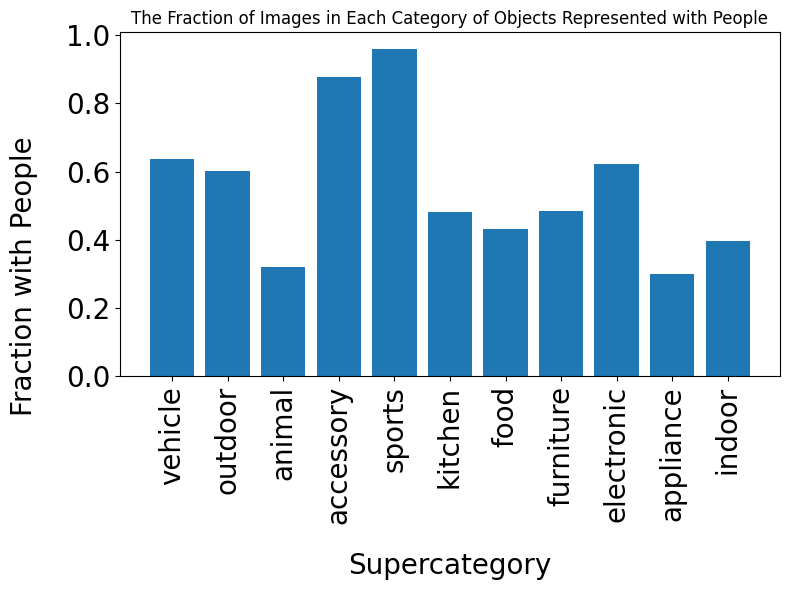

In [59]:
if dataset.group_mapping is not None:
    fraction_with_people()

Which specific objects are over/under represented with people within their object category. 

In [60]:
if dataset.group_mapping is not None:
    interact(represented_with_people, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

interactive(children=(IntSlider(value=10, description='topn', max=30, min=1), Output()), _dom_classes=('widget…

# obj_scn Metric: Scenes and Object Appearance Diversity
<a id="obj_scn"></a>

## Setup
<a id="obj_scn_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide obj_scn Code')

In [ ]:
topn = 10
scene_info = pickle.load(open("results/{}/obj_scn.pkl".format(folder_name), "rb"))
scene_counts = scene_info['scenes']
scene_supercategory = scene_info['scene_supercategory']
scene_instance = scene_info['scene_instance']
supercat_to_scenes_to_features = scene_info['supercat_to_scenes_to_features']

supercategory_info = pickle.load(open("results/{}/obj_cnt.pkl".format(folder_name), "rb"))
supercategory_counts = np.add(supercategory_info['with_people'], supercategory_info['not_with_people'])

info = pickle.load(open('util_files/places_scene_info.pkl', 'rb'))
idx_to_scene = info['idx_to_scene']
idx_to_scenegroup = info['idx_to_scenegroup']
sceneidx_to_scenegroupidx = info['sceneidx_to_scenegroupidx']

entropy_per_instance = np.zeros(len(dataset.categories))
totals_per_instance = np.sum(scene_instance, axis=0)
scene_probs = np.divide(scene_instance, totals_per_instance)
entropy = -np.sum(np.multiply(scene_probs, np.log2(scene_probs+1e-6)), axis=0)
indices = np.argsort(entropy)
cat_to_ent = [('{0}: {1}'.format(dataset.labels_to_names[dataset.categories[index]], round(entropy[index], 3)), index) for index in indices if totals_per_instance[index] > 30]
instance_filepaths = pickle.load(open("results/{}/obj_cnt.pkl".format(folder_name), 'rb'))['instances_size']

class SceneQual():
    def __init__(self):
        self.label = None
        interact(self.obj_scene_div, label=widgets.Dropdown(options=cat_to_ent));

    def obj_scene_div(self, label):
        try: 
            self.label = label
            fig = plt.figure(figsize=(12, 8))

            filepaths = np.unique(np.array([chunk[1] for chunk in instance_filepaths[label]]))
            random.shuffle(filepaths)
            for i in range(30):
                filepath = filepaths[i]
                if i < 15:
                    image, anns = dataset.from_path(filepath)
                    image = image.data.cpu().numpy().transpose(1, 2, 0)
                    ax = fig.add_subplot(3, 5, 1+i)
                    ax.axis("off")
                    im = ax.imshow(image, extent=SAME_EXTENT)
            plt.show()
        except AttributeError: 
            print('Some functionality not available for CocoDatasetNoImages Class')
        
    def click(self, b):  
        if b != '':
            clear_output()
            interact(self.obj_scene_div, label=widgets.Dropdown(options=cat_to_ent, value=self.label));
            
        refresh_button = widgets.Button(description="Click to refresh examples", layout=Layout(width='300px'))
        refresh_button.on_click(self.click)
        output = widgets.Output()
        display(refresh_button, output)

def scene_distribution():
    indices = np.arange(len(idx_to_scenegroup))
    order = np.argsort(scene_counts)
    plt.barh(indices, np.array(scene_counts)[order], tick_label=['\n'.join(textwrap.wrap(idx_to_scenegroup[i], width=30)) for i in np.array(indices)[order]])
    plt.yticks(rotation='vertical')
    plt.yticks(fontsize=10)
    ax = plt.gca()
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.tick_params(axis="y", left=True, right=False, labelleft=True, labelright=False, labelrotation=0)
    plt.ylabel('Scenes')
    plt.xlabel('Quantity')
    plt.title("Distribution of scenes that appear in dataset")
    plt.tight_layout()
    if first_pass:
        to_write[7] = ["(obj_scn) Distribution of scenes that appear in dataset."]
        plt.savefig("results/{0}/{1}/9.png".format(folder_name, save_loc), bbox_inches='tight')
    plt.show()

def scene_supercat(topn):
    mi_wilson = np.zeros_like(scene_supercategory)
    for i in range(len(mi_wilson)):
        for j in range(len(mi_wilson[0])):
            denom = scene_counts[i] + supercategory_counts[j] - scene_supercategory[i][j]
            mi_wilson[i][j] = wilson(scene_supercategory[i][j] / denom, denom)[0]

    flat_norm = mi_wilson.flatten()
    flat_norm[flat_norm!=flat_norm] = -1.
    normalized_indices = np.argsort(flat_norm)
    print("Top cooccurrences:")
    for i in range(topn):
        index = normalized_indices[-1-i]
        a, b = index % len(dataset.supercategories_to_names), index // len(dataset.supercategories_to_names)
        print("{0} - {1}".format(idx_to_scenegroup[b], dataset.supercategories_to_names[a], round(flat_norm[index], 4)))

    print("\nBottom cooccurrences:")
    for i in range(topn):
        index = normalized_indices[i]
        a, b = index % len(dataset.supercategories_to_names), index // len(dataset.supercategories_to_names)
        print("{0} - {1}".format(idx_to_scenegroup[b], dataset.supercategories_to_names[a], round(flat_norm[index], 4)))

def diversify_supercat_by_scene(supercat):
    all_scenes = []
    big = []
    small = []
    person = []
    obj_area = []
    person_area = []
    distance = []
    filepaths = []
    scenes_to_features = supercat_to_scenes_to_features[supercat]
    for scene in scenes_to_features.keys():
        all_scenes.append((scene, len(scenes_to_features[scene])))

        small_ = [chunk[0][0] for chunk in scenes_to_features[scene]]
        filepaths_ = [chunk[1] for chunk in scenes_to_features[scene]]

        small.extend(small_)
        filepaths.extend(filepaths_)
    all_features = small
    cluster_center = np.mean(all_features, axis=0)
    dists = np.linalg.norm(cluster_center-all_features, axis=1)
    sorted_indices = np.argsort(dists)
    tracker = 0
    scene_dists = []
    print("\n{} scene contributions\n".format(dataset.supercategories_to_names[supercat]))
    boundaries = [tracker]
    tsne_features = []
    ind_labels = []
    for i, scene in enumerate(all_scenes):
        med_dist = np.median(dists[tracker:tracker+scene[1]])
        scene_dists.append(med_dist)
        tracker += scene[1]
        boundaries.append(tracker)

        tsne_features.extend(all_features[tracker:tracker+min(100, scene[1])])
        ind_labels.extend([i]*min(100, scene[1]))

        labels = []
    sizes = []
    intensities = []
    for index in np.argsort(scene_dists):
        label = idx_to_scenegroup[all_scenes[index][0]]
        size = all_scenes[index][1]
        intensity = scene_dists[index]
        labels.append(label)
        sizes.append(size)
        intensities.append(intensity)

    plt.close()
    intensities = np.array(intensities - min(intensities))
    intensities /= np.amax(intensities)
    colors = plt.cm.Blues(intensities)
    fig, ax = plt.subplots()
    def pie_label(pct, values):
        amount = int(pct*np.sum(values))
        if pct >= 2.0:
            return "{0}%".format(round(pct, 1))
        else:
            return ''
    wedges, texts, autotexts = ax.pie(sizes, labels = ['' if sizes[i]/sum(sizes) < .02 else i for i in range(len(sizes))], autopct=lambda pct: pie_label(pct, sizes), shadow=False, startangle=90, colors=colors, radius=100, labeldistance=1.1, explode=[10.] * len(sizes))
    for t in texts:
        t.set_fontsize('xx-small')
    for t in autotexts:
        t.set_fontsize('xx-small')
    for w in wedges:
        w.set_edgecolor('black')
        w.set_linewidth(.1)
    ax.legend(wedges, ['{0}: {1}'.format(chunk[0], chunk[1]) for chunk in zip(np.arange(len(labels)), labels)], title='Scene Group Categories', loc='center left', bbox_to_anchor=(1., 0, 0.5, 1.), fontsize='xx-small')
    plt.tight_layout()
    ax.axis('equal')
    # Uncomment below to see pi chart version
#     plt.show()
    plt.close()

    colorz = sns.color_palette('hls', 16)
    xs = np.array(sizes) / sum(sizes)
    xs /= np.amax(xs)
    ys = intensities
    fig = plt.figure(figsize=(9, 5))
    fontsize = 27
    sizez = [64]*16
    plt.scatter(xs, ys, c=colorz, s=sizez)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('Relative Commonness', fontsize=fontsize)
    plt.ylabel('Relative Diversity', fontsize=fontsize)
    
    plt.title("\n{} scene contributions\n".format(dataset.supercategories_to_names[supercat]), fontsize=fontsize)
    
    
    handles = []
    for lab in range(len(sizes)):
        plt.annotate(lab, (xs[lab]+.015, ys[lab]+.01))
        patch = mpatches.Patch(color=colorz[lab], label='{0}: {1}'.format(lab, labels[lab]))
        handles.append(patch)
    fontP = FontProperties()
    fontP.set_size('medium')
    plt.legend(handles=handles, prop=fontP, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if first_pass:
        to_write[8] = ["(obj_scn) An example of how to diversify the appearance diversity of the \"{}\" category by augmenting the dataset with images in different scenes. Appearance diversity can thought of as something like intra-class variation, which is an important feature for object detection. However, there is a tradeoff between the amount of appearance diversity an object in a particular scene brings, and how common this object-scene combination is, which contributes to how easy it is to collect this kind of image.".format(dataset.supercategories_to_names[supercat])]
        plt.savefig("results/{0}/{1}/10.png".format(folder_name, save_loc))
    plt.show()

#     # Visualize the supercategory features colored by their scene as a tsne
#     plot_kwds = {'alpha' : .8, 's' : 30, 'linewidths':0}
#     projection_instances = TSNE().fit_transform(tsne_features)
#     plt.scatter(*projection_instances.T, **plot_kwds, c=[colorz[ind_labels[i]] for i in range(len(tsne_features))])
#     lgd = plt.legend(handles=handles, bbox_to_anchor=(1.04,1), loc="upper left", prop=fontP)
#     plt.show()
#     plt.close()

## Analyses
<a id="obj_scn_analyses"></a>

Scene distribution of entire dataset.

In [ ]:
scene_distribution()

Select the object (which has its scene diversity value next to it) to visualize qualitative examples.

In [ ]:
scene_qual = SceneQual()
scene_qual.click('')

Cooccurrences between scenes and object categories.

In [ ]:
if dataset.group_mapping is not None:
    interact(scene_supercat, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

Actionable insights on how to diversify an object category's appearance. Visualization of tradeoff between how easy it is to find a scene vs how much appearance diversity it brings to the object category.

In [ ]:
if dataset.group_mapping is not None:
    pairs = [(dataset.supercategories_to_names[index], index) for index in supercat_to_scenes_to_features.keys()]
    pairs = sorted(pairs, key=lambda x: x[0])
    interact(diversify_supercat_by_scene, supercat=widgets.Dropdown(options=pairs));

# Setting up summary pdf
<a id="summarypdf"></a>

In [ ]:
first_pass = False

In [ ]:
def write_pdf(numbers):
    for i in numbers:
        if i in to_write.keys():
            for sentence in to_write[i]:
                pdf.write(5, sentence)
                pdf.ln()
            if i == 0:
                pdf.image('results/{0}/{1}/1.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 1:
                pdf.image('results/{0}/{1}/2.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 2:
                pdf.image('results/{0}/{1}/3.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 3:
                pdf.image('results/{0}/{1}/4.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 4:
                y_spot = pdf.get_y()
                pdf.image('results/{0}/{1}/5.png'.format(folder_name, save_loc), w=85)
                after_y_spot = pdf.get_y()
                if after_y_spot < y_spot:
                    y_spot = 10
                pdf.image('results/{0}/{1}/7.png'.format(folder_name, save_loc), w=85, x=95, y=y_spot)
                pdf.ln()
                pdf.image('results/{0}/{1}/6.png'.format(folder_name, save_loc),h=80)
                pdf.ln()
            elif i == 5:
                pdf.image('results/{0}/{1}/8.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 7:
                pdf.image('results/{0}/{1}/9.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            elif i == 8:
                pdf.image('results/{0}/{1}/10.png'.format(folder_name, save_loc), h=80)
                pdf.ln()
            pdf.ln(h=3)
            pdf.dashed_line(10, pdf.get_y(), 200, pdf.get_y())
            pdf.ln(h=3)

In [ ]:
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.write(5, "Object-Based Summary")
pdf.ln()
pdf.ln()

# Overview Statistics
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Overview Statistics")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
write_pdf([2, 5, 7])

# Interesting findings
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Sample Interesting Findings")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
write_pdf([0, 1, 3, 4, 6, 8])

# Interesting findings
pdf.set_font('Arial', 'B', 12)
pdf.write(5, "Some of the other metrics in the notebook")
pdf.ln()
pdf.ln(h=3)
pdf.line(10, pdf.get_y(), 200, pdf.get_y())
pdf.ln(h=3)
pdf.set_font('Arial', '', 12)
pdf.write(5, "- (obj_cnt) Cooccurrences of objects as a hierarchical graph")
pdf.ln()
pdf.write(5, "- (obj_cnt) Finer grained look at distribution within each object category ")
pdf.ln()
pdf.write(5, "- (obj_siz) Size of each object category")
pdf.ln()
pdf.write(5, "- (obj_scn) Qualitative look at what each object's scenes are like")
pdf.ln()
pdf.write(5, "- (obj_scn) Highest/lowest cooccurrences between object categories and scenes")
pdf.ln()

pdf.output('results/{0}/{1}/summary.pdf'.format(folder_name, save_loc), "F")